In [1]:
%reset -f
from pythonrc import *

In [2]:
time_step = 1.0

tunnel.extra_attributes["rate_limit"] = 1.0
voithschneider_port.extra_attributes["rate_limit"] = 1.0
voithschneider_starboard.extra_attributes["rate_limit"] = 1.0


actuators = [tunnel, voithschneider_port, voithschneider_starboard]
force_torque_components = [
    skadipy.allocator.ForceTorqueComponent.X,
    skadipy.allocator.ForceTorqueComponent.Y,
    skadipy.allocator.ForceTorqueComponent.N,
]

allocators = []
gamma = [1e-1, 1e-1]
mu = [1e-1, 1e-1]
rho = [1.0, 1.0]
zeta = [1.0, 1.0]
lambda_p = [0.99, 0.0]


for g, m, r, l, z in zip(gamma, mu, rho, lambda_p, zeta):

    allocators.append(
        skadipy.allocator.reference_filters.MinimumMagnitudeAndAzimuth(
            actuators=actuators,
            force_torque_components=force_torque_components,
            control_barrier_function=skadipy.safety.ControlBarrierFunctionType.ABSOLUTE,
            derivative=skadipy.toolbox.derivative.ExponentialSmoothing(r=0.1),
            gamma=g,
            mu=m,
            rho=r,
            zeta=z,
            time_step=time_step,
            lambda_=l,
        )
    )

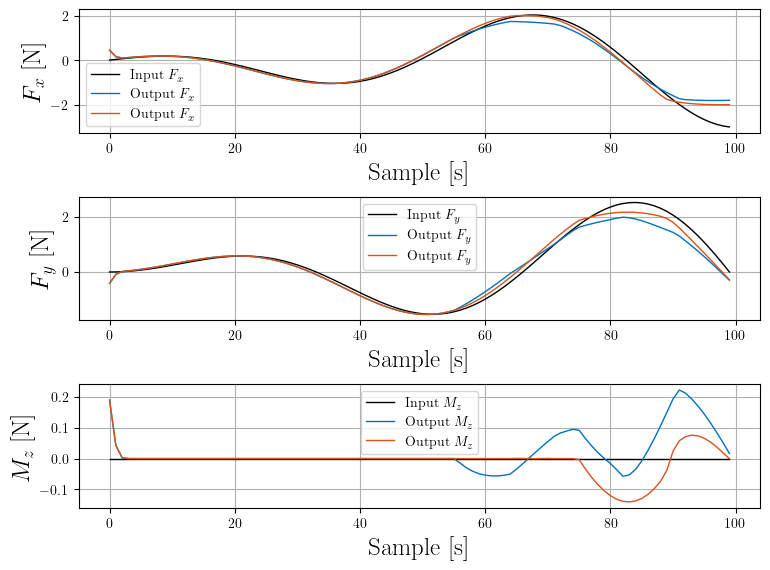

In [3]:
data = generate_spiral_dataset(
    num_points=100,
    num_turns=1.5,
    k=3,
)

tau_cmd = np.concatenate(
    (data, np.zeros((np.shape(data)[0], 4))),
    axis=1
)
d_tau_cmd = np.gradient(tau_cmd, axis=0) / time_step


for allocator in allocators:
    allocator._xi = np.array([[0.0, 0.5, -0.5, 0.5, -0.5]]).T


xi_hist, theta_hist, tau_hist = run_tests(tau_cmd=tau_cmd, d_tau_cmd=d_tau_cmd, allocators=allocators)
plot_histories(tau_cmd=tau_cmd, tau_alloc=tau_hist)

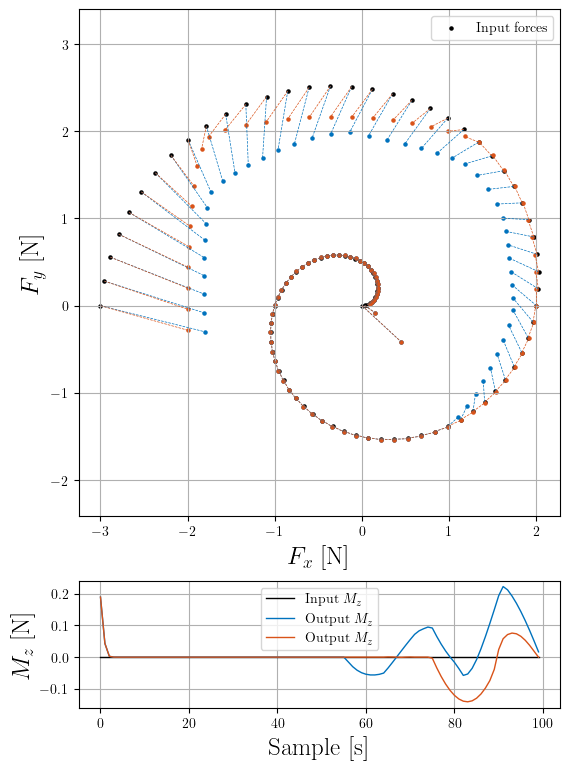

In [4]:
plot_2d_allocation(tau_cmd=tau_cmd, allocators=allocators, tau_hist=tau_hist)

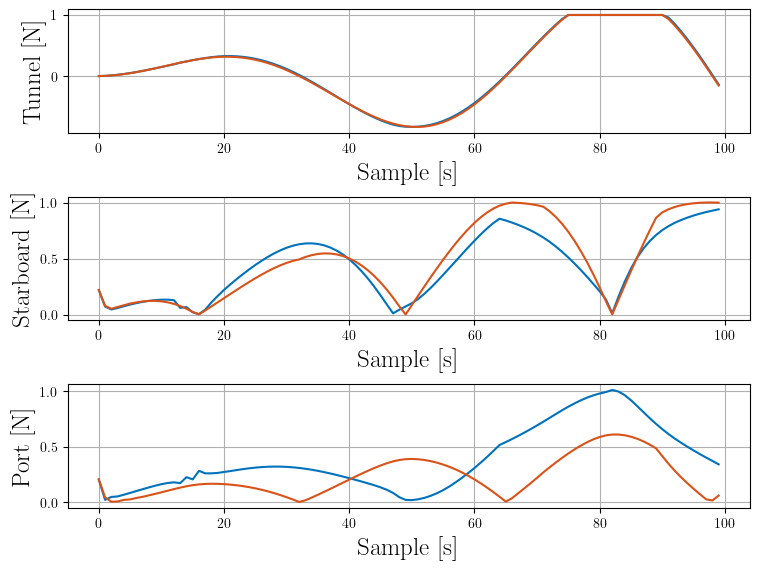

In [5]:
plot_thruster_forces(xi_hist)

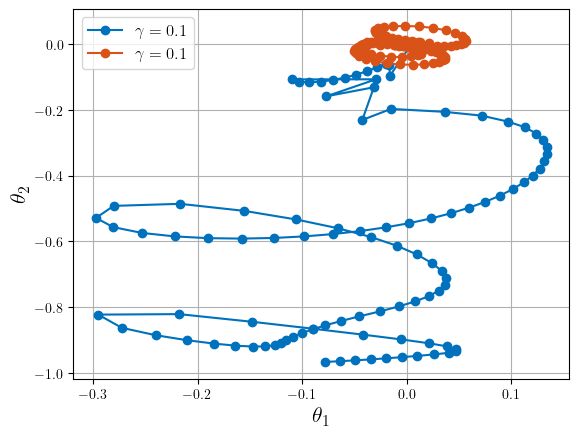

In [6]:
plot_theta_histories(theta_hist)
l = []
for i in gamma:
    l.append(r"$\gamma = {}$".format(i))

plt.legend(l, fontsize=12)

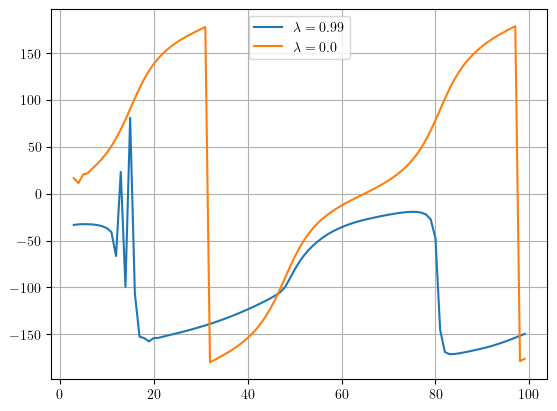

In [7]:
angles = []
for control_input in xi_hist:
    a = np.empty((len(control_input), 2))
    for i, u in enumerate(control_input):
        a2 = np.arctan2(u[2], u[1])
        a3 = np.arctan2(u[4], u[3])
        a[i] = np.array([a3])
    angles.append(a)

for _, angle in enumerate(angles):
    angle[0:3,0] = None

plt.clf()
for _, angle in enumerate(angles):
    plt.plot(np.degrees(angle[:,0]))
    # plt.plot(np.degrees(np.unwrap(angle[:,0])))
    pass


l = []
for i in lambda_p:
    l.append(f"$\lambda = {i}$")

plt.legend(l)
# plt.plot(np.unwrap(angles[3][:,0]))
plt.grid(True)

In [8]:
save_mat(
    filename="data/014.mat",
    inputs=tau_cmd,
    xi=xi_hist,
    thetas=theta_hist,
    outputs=tau_hist,
    zeta=zeta,
    rho=rho,
    gamma=gamma,
    mu=mu,
    lambda_p=lambda_p,
    thruster=voithschneider_port
)